In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import math
import random
import seaborn as sns
import scipy

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
musicData = pd.read_csv('dataset-of-10s.csv')

## Part 1 - Linear Regression

Recall: our linear regression from mission 3

In [4]:
modelData = musicData[['loudness','speechiness','key','valence']]
sampledData = modelData.sample(200, random_state=1)

In [5]:
def make_x_y(data, n=200):
    x = data[:,[0,1,2]]
    x = np.append(np.ones((n,1)), x, axis=1)
    y = data[:, -1].copy()
    return x,y

In [6]:
x, y = make_x_y(sampledData.to_numpy())

In [7]:
linreg = sm.OLS(y,x).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     6.603
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           0.000284
Time:                        16:26:50   Log-Likelihood:               -0.74965
No. Observations:                 200   AIC:                             9.499
Df Residuals:                     196   BIC:                             22.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5254      0.043     12.111      0.000       0.440       0.611
x1             0.0123      0.003      4.276      0.000       0.007       0.018
x2             0.0085      0.190      0.045      0.965      -0.366       0.383
x3             0.0031      0.005      0.668      0.505      -0.006       0.012
==============================================================================
Omnibus:                       14.347   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.578
Skew:                           0.209   Prob(JB):                       0.0373
Kurtosis:                       2.216   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### We got the following model:
$$ Y_{valence}=0.5254 + 0.0123x_{loudness} + 0.0085x_{speechiness} + 0.0031x_{key} $$
$$ \hat\beta_{sample}=(0.5254, 0.0123, 0.0085, 0.0031) $$

### Question 1

In [8]:
# for this mission we define B and alpha
B = 400
alpha = 0.05

In [9]:
mu_hat = np.divide(np.sum(x),len(x))
sigma2_hat = np.divide(np.sum([np.power(xi - mu_hat, 2) for xi in x]), len(x) - 1)
sigma_hat = np.sqrt(sigma2_hat)

In [10]:
def regular_bootstrap(data, B):
    se_list = []
    params = []
    for _ in range(B):
        samples = data.sample(200, replace=True)
        x, y = make_x_y(samples.to_numpy())
        linear_reg = sm.OLS(y, x).fit()
        se_list.append(linear_reg.ssr/linear_reg.df_resid)
        params.append(linear_reg.params)
    return se_list, params

In [11]:
beta_confidence_intervals = []

#### Question 1A

In [12]:
def beta_confidence_interval(x, beta, z_normal, i):
    C = np.linalg.inv(np.dot(x.T, x))
    left_limit = beta - z_normal * np.sqrt((linreg.ssr/linreg.df_resid) * C[i][i])
    right_limit = beta + z_normal * np.sqrt((linreg.ssr/linreg.df_resid) * C[i][i])
    return [left_limit.tolist(), right_limit.tolist()]

In [13]:
normal_aprox_ci = []
for i, beta_hat in enumerate(linreg.params):
    norm_ci = beta_confidence_interval(x, linreg.params[i], 1.96, i)
    normal_aprox_ci.append(norm_ci)
    print(f'beta^{i}={beta_hat}, CI={norm_ci}')
beta_confidence_intervals.append(normal_aprox_ci)

beta^0=0.5254153342406156, CI=[0.44038411425910284, 0.6104465542221283]
beta^1=0.0122954389510142, CI=[0.006659896096373009, 0.01793098180565539]
beta^2=0.008456845979437633, CI=[-0.3635978165116919, 0.38051150847056714]
beta^3=0.0031338680594543353, CI=[-0.006060523255492296, 0.012328259374400966]


#### Question 1B

In [14]:
def beta_normal_aprox_ci(beta_hat, vars_beta, z_normal, B):
    params_i = [param[index] for param in params]
    se_hat_boot = np.sqrt((1/B)*np.sum([beta_boot_i**2 for beta_boot_i in params_i])-((1/B)*np.sum(params_i))**2)
    return [beta_hat - z_normal * se_hat_boot, beta_hat + z_normal * se_hat_boot]

In [15]:
_, params = regular_bootstrap(sampledData, B)
boot_normal_aprox_ci = []
for index, beta_hat in enumerate(linreg.params): 
    boot_normal_ci = beta_normal_aprox_ci(beta_hat, params, 1.96, B)
    boot_normal_aprox_ci.append(boot_normal_ci)
    print(f'beta^{index}={beta_hat}, CI={boot_normal_ci}')
beta_confidence_intervals.append(boot_normal_aprox_ci)

beta^0=0.5254153342406156, CI=[0.443094484394017, 0.6077361840872142]
beta^1=0.0122954389510142, CI=[0.0065758082271324585, 0.018015069674895943]
beta^2=0.008456845979437633, CI=[-0.3891689566719397, 0.40608264863081495]
beta^3=0.0031338680594543353, CI=[-0.005266647397880932, 0.011534383516789603]


#### Question 1C

In [16]:
def pivotal_confidence_interval(beta_hat, params, alpha, index):
    params_i = [param[index] for param in params]
    return [2 * beta_hat - np.percentile(params_i, 100 - (alpha*100)/2), 2 * beta_hat - np.percentile(params_i, (alpha*100)/2)]

In [17]:
_, params = regular_bootstrap(sampledData, B)
pivotal_ci = []
for index, beta_hat in enumerate(linreg.params): 
    piv_ci = pivotal_confidence_interval(beta_hat, params, alpha, index)
    pivotal_ci.append(piv_ci)
    print(f'beta^{index}={beta_hat}, CI={piv_ci}')
beta_confidence_intervals.append(pivotal_ci)

beta^0=0.5254153342406156, CI=[0.43377047777968714, 0.5979650137479255]
beta^1=0.0122954389510142, CI=[0.006390148354267114, 0.017752527961162157]
beta^2=0.008456845979437633, CI=[-0.31533794757495337, 0.42685591901118763]
beta^3=0.0031338680594543353, CI=[-0.005718041668004374, 0.011809981236222622]


#### Question 1D

In [18]:
def bootstrap_pencentile_ci(params, alpha, index):
    params_i = [param[index] for param in params]
    return [np.percentile(params_i, (alpha*100)/2), np.percentile(params_i, 100 - (alpha*100)/2)]

In [19]:
_, params = regular_bootstrap(sampledData, B)
percentile_ci = []
for index, beta_hat in enumerate(linreg.params): 
    percent_ci = bootstrap_pencentile_ci(params, alpha, index)
    percentile_ci.append(percent_ci)
    print(f'beta^{index}={beta_hat}, CI={percent_ci}')
beta_confidence_intervals.append(percentile_ci)

beta^0=0.5254153342406156, CI=[0.4439194461020596, 0.6077180410029722]
beta^1=0.0122954389510142, CI=[0.0062232391104840796, 0.017946238034129616]
beta^2=0.008456845979437633, CI=[-0.40218923625142594, 0.31856436205202904]
beta^3=0.0031338680594543353, CI=[-0.005422512979008035, 0.013406694908892609]


### Question 2

In [20]:
matrix = modelData.to_numpy()
xfull = matrix[:,[0,1,2]]
xfull = np.append(np.ones((len(xfull),1)), xfull, axis=1)
yfull = matrix[:, -1].copy()
full_model = sm.OLS(yfull, xfull).fit()

In [21]:
def calc_ci_percentage(ci, beta):
    percentage = 0
    for index in range(len(ci)):
        if beta <= ci[index][1] and beta >= ci[index][0]:
            percentage += 1
    percentage = percentage / len(ci)
    return percentage

In [22]:
def ci_boxplot(intervals):
    for index, beta in enumerate(full_model.params):
        ci_intervals = [interval[index] for interval in intervals]
        print(f"number of interval that cover the beta{index}={beta}: {calc_ci_percentage(ci_intervals, beta) * len(ci_intervals)}")
        plt.figure(figsize=(5,5))
        # plot box plots of each sample mean.
        plt.boxplot(ci_intervals)
        plt.plot([1, len(ci_intervals)],[beta,beta], 'k-', lw=1, color='red')
        plt.show()

number of interval that cover the beta0=0.5497194749387274: 4.0


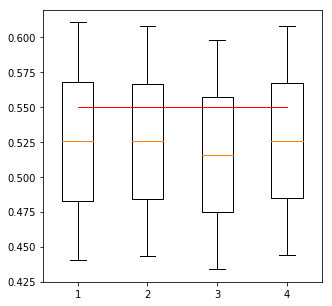

number of interval that cover the beta1=0.015170285752257049: 4.0


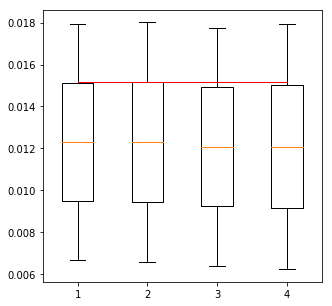

number of interval that cover the beta2=0.03551600892959615: 4.0


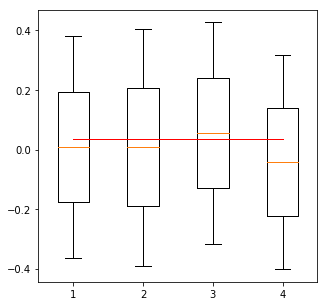

number of interval that cover the beta3=0.0010737015171123543: 4.0


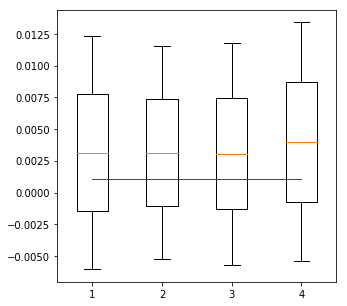

In [23]:
ci_boxplot(beta_confidence_intervals)

### Question 3

In [24]:
smallerSampledData = pd.concat([modelData, sampledData]).drop_duplicates(keep=False).sample(100, random_state=1)

In [25]:
matrix_new = smallerSampledData.to_numpy()
x_new = matrix_new[:,[0,1,2]]
x_new = np.append(np.ones((100,1)), x_new, axis=1)
y_new = matrix_new[:, -1].copy()

#### Question 3A

In [26]:
y_pred_new = linreg.predict(x_new)

#### Question 3B

We learned that $ \hat E[Y_{new}|X_{new}]=\hat Y_{new} $ and we will use it in our bootstrap CI.

In [27]:
def expectation_bootstrap(data, B, x_new):
    expectations = []
    for _ in range(B):
        samples = data.sample(200, replace=True)
        x, y = make_x_y(samples.to_numpy())
        bootstrap_linreg = sm.OLS(y, x).fit()
        y_pred = bootstrap_linreg.predict(x_new)
        expectations.append(y_pred)
    return expectations

In [28]:
def expectation_ci(y_hat, expectations, alpha, index):
    expectation_i = [expectation[index] for expectation in expectations]
    return [2 * y_hat - np.percentile(expectation_i, 100 - (alpha*100)/2), 2 * y_hat - np.percentile(expectation_i, (alpha*100)/2)]

In [29]:
expectations = expectation_bootstrap(sampledData, B, x_new)

expectations_ci = []

for index in range(len(x_new)):
    expectations_ci.append(expectation_ci(y_pred_new[index], expectations, alpha, index))

#### Question 3C

In [30]:
def calc_ci_percentage(ci, y_new):
    percentage = 0
    for index in range(len(x_new)):
        if y_new[index] <= ci[index][1] and y_new[index] >= ci[index][0]:
            percentage += 1
    percentage = percentage / len(ci)
    return percentage
print('out of our 100 samples {}% of the real y value are inside their respected ci'.format(calc_ci_percentage(expectations_ci, y_new)*100))

out of our 100 samples 24.0% of the real y value are inside their respected ci


number of intervals that cover the expected values: 24.0


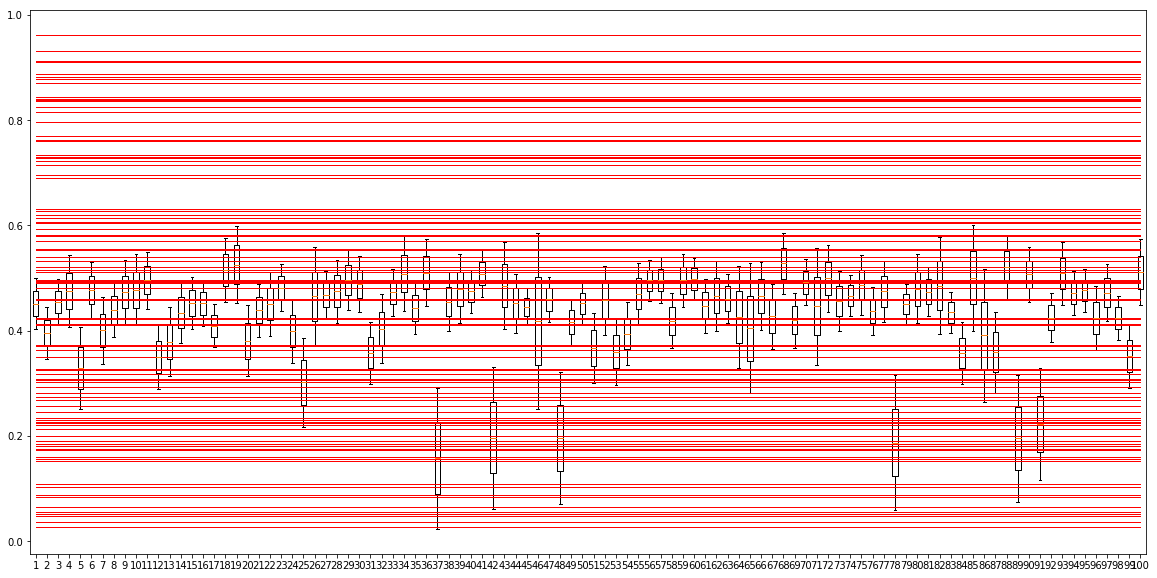

In [31]:
print("number of intervals that cover the expected values:", calc_ci_percentage(expectations_ci, y_new)*100)
# set figure size.
plt.figure(figsize=(20,10))
# plot box plots of each sample mean.
plt.boxplot(expectations_ci)
plt.plot([1, 100],[y_new,y_new], 'k-', lw=1, color='red')
# show plot.
plt.show()

## Part 2 - Tests

### Question 1

Is the distribution of $X_{key}:mode=major (1)$ bigger than the distribution of $X_{key}:mode=minor(0)$?

### Question 2

In [32]:
sampleData = musicData.sample(200, random_state=2)

X = sampleData['key']
Y = sampleData['mode']

X_minor = sampleData[sampleData['mode'] == 0]['key']
X_major = sampleData[sampleData['mode'] == 1]['key']

### Question 3

#### Question 3A

In [33]:
mu_minor_MLE = np.divide(np.sum(X_minor), len(X_minor))
mu_major_MLE = np.divide(np.sum(X_major), len(X_major))

$\mu_1=\mu_{minor}, \mu_2=\mu_{major}$ <br>
$\delta = \mu_{minor} - \mu_{major} \Rightarrow \hat\delta = \hat \mu_{minor} - \hat \mu_{major}$

In [34]:
delta_MLE = mu_minor_MLE - mu_major_MLE

We used two known MLEs to estimate our $\mu$s and so $\hat\delta$ is an MLE too as an estimator that contains other MLEs

#### Question 3B

In [35]:
def delta_bootstrap(B, sampleData):
    deltas = []
    for _ in range(B):
        data = sampleData.sample(200, replace=True)
        samples_minor = data[data['mode'] == 0]['key']
        samples_major = data[data['mode'] == 1]['key']
        hat_delta = np.mean(samples_minor) - np.mean(samples_major)
        deltas.append(hat_delta)
    return deltas

In [36]:
def delta_ci(alpha, deltas, delta_hat):
    return [2 * delta_hat - np.percentile(deltas, 100 - (alpha*100)/2), 2 * delta_hat - np.percentile(deltas, (alpha*100)/2)]

In [37]:
deltas = delta_bootstrap(B, sampleData)
delta_confidence_interval = delta_ci(alpha, deltas, delta_MLE)
print(f'delta^={delta_MLE}, CI={delta_confidence_interval}')

delta^=1.8353532044983076, CI=[0.8515592948495021, 2.854118892035964]


#### Question 3C

In [38]:
Xfull_minor = musicData[musicData['mode'] == 0]['key']
Xfull_major = musicData[musicData['mode'] == 1]['key']

In [39]:
full_mu_minor_MLE = np.divide(np.sum(Xfull_minor), len(Xfull_minor))
full_mu_major_MLE = np.divide(np.sum(Xfull_major), len(Xfull_major))

In [40]:
full_delta_MLE = full_mu_minor_MLE - full_mu_major_MLE

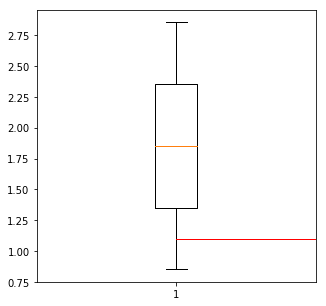

In [41]:
plt.figure(figsize=(5,5))
# plot box plots of each sample mean.
plt.boxplot(delta_confidence_interval)
plt.plot([1, len(delta_confidence_interval)],[full_delta_MLE,full_delta_MLE], 'k-', lw=1, color='red')
plt.show()

We see that our full data delta is inside our CI. We chose to use a pivotal bootstrap CI.

#### Question 3D

######  Wald Test

In [42]:
def wald_test(X_major, X_minor):
    n_major = len(X_major)
    n_minor = len(X_minor)
    Sp = np.sqrt(((n_major - 1) * X_major.var() + (n_minor - 1) * X_minor.var()) / (n_major + n_minor - 2))
    Wald = (X_major.mean() - X_minor.mean()) / (Sp * np.sqrt(1/n_major + 1/n_minor))
    pvalueWald = 2 * scipy.stats.norm.cdf(-abs(Wald))       
    return Wald, pvalueWald

In [43]:
Wald, pvalueWald = wald_test(X_major.values, X_minor.values)
print("Wald        ={}".format(Wald))
print("Wald P-value={}".format(pvalueWald))

Wald        =-3.6621203372778943
Wald P-value=0.0002501363030971642


###### Permutation Test

In [44]:
def TS(X_major, X_minor):
    X_major_mean = X_major.mean()
    X_minor_mean = X_minor.mean()
    TS_ = np.abs(X_major_mean - X_minor_mean)
    return TS_
    
def permutation_test(X_major, X_minor, permutation_num):
    T0 = TS(X_major, X_minor)
    X = np.concatenate([X_major, X_minor])
    n, k = len(X_major), 0
    for j in range(permutation_num):
        np.random.shuffle(X)
        Tj = TS(X[:n], X[n:])
        if T0 <= Tj:
            k += 1
    return k / permutation_num

permutation_pvalue = permutation_test(X_major.values, X_minor.values, 100000)
print("permutation p-value={}".format(permutation_pvalue))

permutation p-value=0.00036


Permutation P-Value smaller then $\alpha$=0.05, then $H_0$ is rejected

### Question 4

#### Question 4A

In [45]:
m_minor_MLE = np.median(X_minor)
m_major_MLE = np.median(X_major)

print(m_minor_MLE, m_major_MLE)

7.0 5.0


$m_1=m_{minor}, m_2=m_{major}$ <br>
$\delta = m_{minor} - m_{major} \Rightarrow \hat\delta = \hat m_{minor} - \hat m_{major}$

In [46]:
delta_MLE = m_minor_MLE - m_major_MLE
print(delta_MLE)

2.0


There is no MLE for the median because there is no model and thus no MLE for delta based on the median.

#### Question 4B

In [47]:
delta_confidence_interval = delta_ci(alpha, deltas, delta_MLE)
print(f'delta^={delta_MLE}, CI={delta_confidence_interval}')

delta^=2.0, CI=[1.1808528858528868, 3.1834124830393487]


#### Question 4C

In [48]:
full_m_minor_MLE = np.median(Xfull_minor)
full_m_major_MLE = np.median(Xfull_major)

full_delta_MLE = full_m_minor_MLE - full_m_major_MLE

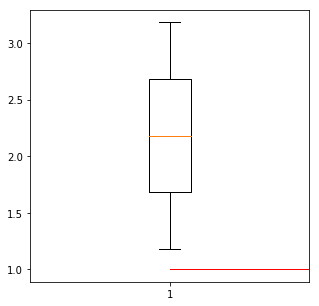

In [49]:
plt.figure(figsize=(5,5))
# plot box plots of each sample mean.
plt.boxplot(delta_confidence_interval)
plt.plot([1, len(delta_confidence_interval)],[full_delta_MLE,full_delta_MLE], 'k-', lw=1, color='red')
plt.show()

#### Question 4D

###### Permutation Test

In [50]:
def TS(X_major, X_minor):
    X_major_median = np.median(X_major)
    X_minor_median = np.median(X_minor)
    TS_ = np.abs(X_major_median - X_minor_median)
    return TS_

In [51]:
permutation_pvalue = permutation_test(X_major.values, X_minor.values, 100000)
print("permutation p-value={}".format(permutation_pvalue))

permutation p-value=0.04941


Permutation P-Value smaller then $\alpha$=0.05, then $H_0$ is rejected

#### Question 4E

As we see on our previous parts of the project, our data does not look like a normal distribution,
in this question we can not use the Central Limit Theorem, because we test the medians and not the means.
Because of that the assumption of Wald and T tesets are not existing and we can't use this tests. 

### Question 5

In [52]:
sampleData_sorted = sampleData.sort_values(by=['key'])
sampleData_sorted['order'] = np.arange(1, len(sampleData_sorted) + 1)

X_minor = sampleData_sorted[sampleData_sorted['mode'] == 0]['order'].values
X_major = sampleData_sorted[sampleData_sorted['mode'] == 1]['order'].values


In [53]:
Ws = np.sum(X_major)
EWs = (len(X_major) * (len(sampleData_sorted) + 1)) / 2
VarWs = (len(X_minor) * len(X_major) * (len(sampleData_sorted) + 1)) / 12
TS_ = (Ws - EWs) / np.sqrt(VarWs)
print(TS_)

Zalpha = -1.96

-3.5092419228948004


We can use the normal approximation. $Xmajor$ and $Xminor$ have different values from each other.<br/>
$TS$ < $Z_\alpha$(=-1.96), than $H_0$ accepted